In [3]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-0rzk9rgx
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-0rzk9rgx
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=8270f989683afbac3d1f3c35dbfbbdd9f3ed10cab3f0044c4695af6a203c3371
  Stored in directory: /tmp/pip-ephem-wheel-cache-ydbvp32p/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [4]:
import tensorflow as tf

In [5]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE


In [6]:
dataset , metadata = tfds.load('cycle_gan/cezanne2photo',with_info = True , as_supervised = True)

trainnorm , trainmonet = dataset['trainA'] , dataset['trainB']
testnorm , testmonet = dataset['testA'] , dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/525 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/cezanne2photo/3.0.0.incompleteUK8GCR/cycle_gan-trainA.tfrecord*.…

Generating trainB examples...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/cezanne2photo/3.0.0.incompleteUK8GCR/cycle_gan-trainB.tfrecord*.…

Generating testA examples...:   0%|          | 0/58 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/cezanne2photo/3.0.0.incompleteUK8GCR/cycle_gan-testA.tfrecord*..…

Generating testB examples...:   0%|          | 0/751 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/cezanne2photo/3.0.0.incompleteUK8GCR/cycle_gan-testB.tfrecord*..…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/cezanne2photo/3.0.0. Subsequent calls will reuse this data.


In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image , size = [IMG_HEIGHT , IMG_WIDTH ,3])

  return cropped_image

In [9]:
#Normalize image -> [-1,1]

def normalize(image):
  image = tf.cast(image , tf.float32) #COnvert to floating for higher precision
  image = (image / 127.5) - 1   #0-255 to -1/1
  return image

In [10]:
def random_jitter(image):
  image = tf.image.resize(image , [286,286] , method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop(image)
  #random mirroring and cropping
  image = tf.image.random_flip_left_right(image)

  return image

In [11]:
def preprocess_image_train(image , label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [12]:
def preprocess_image_test(image , label):
  image = normalize(image)  #[-1,1]
  return image

In [13]:
trainnorm = trainnorm.cache().map(
    preprocess_image_train , num_parallel_calls = AUTOTUNE).shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE)

trainmonet = trainmonet.cache().map(
    preprocess_image_train ,num_parallel_calls = AUTOTUNE).shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
testnorm = testnorm.cache().map(
    preprocess_image_test , num_parallel_calls = AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

testmonet = testmonet.cache().map(
    preprocess_image_test , num_parallel_calls = AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [15]:
sample_norm = next(iter(trainnorm))
sample_monet = next(iter(trainmonet))

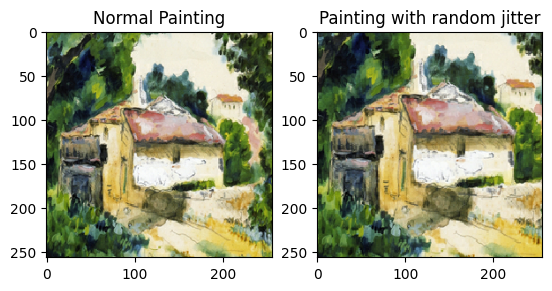

In [16]:
plt.subplot(121)
plt.title("Normal Painting")
plt.imshow(sample_norm[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Painting with random jitter")
plt.imshow(random_jitter(sample_norm[0])*0.5 + 0.5)

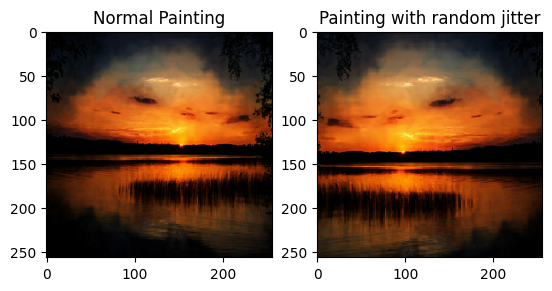

In [17]:
plt.subplot(121)
plt.title("Normal Painting")
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Painting with random jitter")
plt.imshow(random_jitter(sample_monet[0])*0.5 + 0.5)

In [18]:
#2 generators
#G - transforms x -y
#F - transforms y - x
#2 Discriminators D_x and D_y
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS , norm_type = 'instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS , norm_type = 'instancenorm')

discriminator_x = pix2pix.discriminator(norm_type = 'instancenorm' ,target = False)
discriminator_y = pix2pix.discriminator(norm_type = 'instancenorm' , target = False)



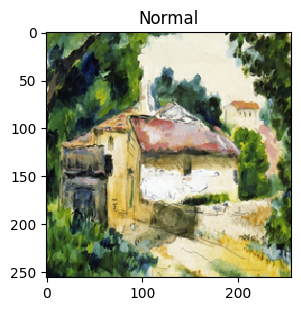

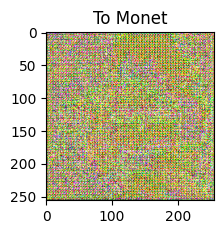

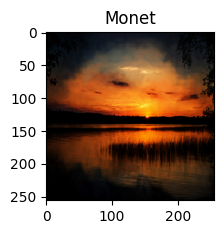

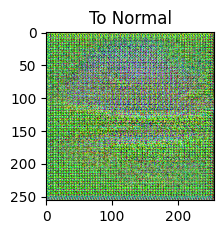

In [19]:
to_monet = generator_g(sample_norm)
to_normal= generator_f(sample_monet)

plt.figure(figsize = (7,7))
contrast = 8

imgs = [sample_norm , to_monet , sample_monet , to_normal]
title = ['Normal' , 'To Monet' , 'Monet' ,'To Normal']

for i in range(len(imgs)):
  plt.subplot(2, 2 ,i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
  plt.show()


In [20]:
#Loss Functions

LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits = True)


In [21]:
def discriminator_loss(real , generated):
  real_loss = loss_obj(tf.ones_like(real)  , real)  #Real values , predicted

  generated_loss = loss_obj(tf.zeros_like(generated) , generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [22]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated) , generated)


In [23]:
def cycle_loss(real_image , cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA*loss1

In [24]:
#Identity loss (G(y) - y) + (F(x) - x) (abs diff)

def identity_loss (real_image , same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [25]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4 , beta_1 = 0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4 , beta_1 = 0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4 , beta_1 = 0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4 , beta_1 = 0.5)


In [26]:
#CHECKPOINTS
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [27]:
def generate_images(model , test_input):
  prediction = model(test_input)

  plt.figure(figsize= (12,12))

  disp_list = [test_input[0] , prediction[0]]
  title =['Input image' , 'Predicted Image']

  for i in range(2):
    plt.subplot(1 , 2 ,i+1)
    plt.title(title[i])
    plt.imshow(disp_list[i] * 0.5 + 0.5)
    plt.axis('off')

  plt.show()

In [28]:
#Training the model
@tf.function
def train_step(real_x , real_y):
  with tf.GradientTape(persistent = True) as tape:
    #G x to y
    #F y to x

    fake_y = generator_g(real_x , training = True)  #G translates x to y
    cycled_y = generator_f(fake_y , training = True)  #cycling the fake_y

    fake_x = generator_f(real_y , training = True)
    cycled_x = generator_g(fake_x , training = True)

    #Same x ,y for calculating identity loss
    same_x = generator_f(real_x , training = True)
    same_y = generator_g(real_y , training = True)


    #Discriminator
    disc_real_x = discriminator_x(real_x , training = True)
    disc_real_y = discriminator_y(real_y , training = True)

    disc_fake_x = discriminator_x(fake_x , training = True)
    disc_fake_y = discriminator_y(fake_y , training = True)

    #Calculating Loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = cycle_loss(real_x , cycled_x) + cycle_loss(real_y , cycled_y)

    #Total gen loss = cycle loss + adversarial loss
    total_gen_g_loss = total_cycle_loss + gen_g_loss + identity_loss(real_y , same_y)
    total_gen_f_loss = total_cycle_loss + gen_f_loss + identity_loss(real_x , same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    #Calculating Gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)


    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

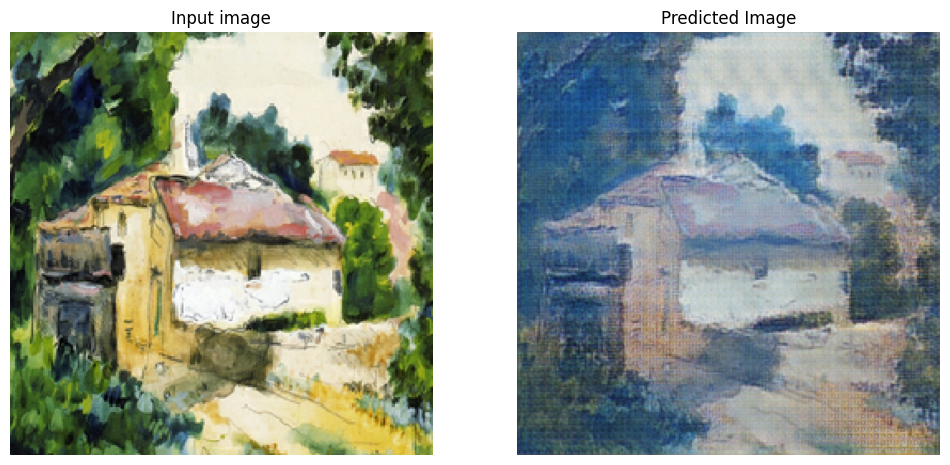

Time taken for epoch 12 is 222.1967055797577 sec

...............................................

KeyboardInterrupt: 

In [29]:
EPOCHS = 50
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((trainnorm, trainmonet)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)

  generate_images(generator_g, sample_norm)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))